Questao 1) escolher um sinal de audio, fazer a analise senoidal e depois resintetiza-lo

In [83]:
import librosa.core as lc
import librosa.display as ld
import librosa
import scipy
from matplotlib import pyplot as plt
import numpy as np
import os
import IPython.display as ipd
import soundfile as sf
from scipy.signal import find_peaks



Loading file

In [84]:
base_dir="AudioFiles"
file_name="há gente aqui_RED.wav"
file_path = os.path.join(base_dir,file_name)
samples, sample_rate = lc.load(file_path, sr=44100)

STFT of the original signal to pass it to the frequency domain

In [85]:
window_length=0.02 #20ms, minimum variation we (humans) can hear
nfft=int(window_length*sample_rate)

stftMat = lc.stft(samples, n_fft=nfft)

In [86]:
ipd.Audio(samples,rate=sample_rate)

Frequencies of the bins

In [87]:
freqs = np.arange(0,1 + nfft/2)*sample_rate/nfft

In [88]:
def tpsw(spectrum,M = 10, N = 10,alpha=1.1):
    """
    Apply TPSW to one window of the audio signal
    M should be chosen such that it has the same length of the wider peaks
    alpha should be small enough such that alpha*Z is lower than the peaks and higher than noise level.
    2<alpha<8 are the recommended values
    """
    #primeira etapa
    h_sw = np.zeros(2*N - 1)
    h_sw[0:M]=1
    h_sw[2*N-1 - M:]=1
    S = scipy.signal.convolve(spectrum,h_sw)[N - 1:spectrum.shape[0] + N - 1]
    #segunda etapa
    choice_matrix = spectrum <= alpha*S
    Z = choice_matrix*spectrum 
    Z = Z -1*(choice_matrix -1)*S
    #terceira etapa, filtro de media movel
    avg_w = np.ones(2*N - 1)/(2*N - 1)
    result =  scipy.signal.convolve(Z,avg_w)[N - 1:spectrum.shape[0] + N - 1]
    return result

In [89]:
def tpsw_complete(audio_spec,M = 10, N = 30, alpha = 2):
    """
    Apply tpsw to the whole audio signal 
    """
    filtered = np.zeros([audio_spec.shape[0],audio_spec.shape[1]])    
    for i in range(audio_spec.shape[1]):
        filtered[:,i] = tpsw(audio_spec[:,i],M,N,alpha)
    return filtered

In [90]:
frequencies_weights = tpsw_complete(stftMat,N = 10,alpha=2,M = 5)

/Users/danielmendonca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [104]:
S_tilted = stftMat/np.abs(frequencies_weights)
S_tilted = np.nan_to_num(S_tilted)

/Users/danielmendonca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


We can clearly see the balanced spectrum now

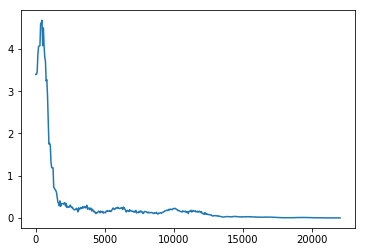

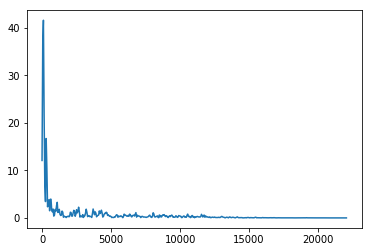

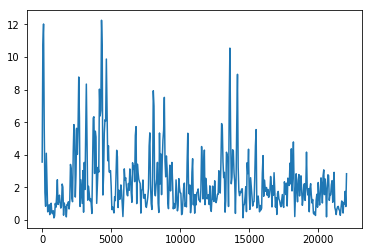

In [96]:
freqs = np.arange(0,1 + nfft/2)*sample_rate/nfft

plt.plot(freqs,np.abs(a[:,2000]))
plt.show()

plt.plot(freqs,np.abs(stftMat[:,2000]))
plt.show()

plt.plot(freqs,np.abs(S_tilted[:,2000]))
plt.show()



In [98]:
def find_column_peaks(S_tilted):
    """
    function to find peaks using the average per frame as a minimum threshold
    """
    #find mean for each window
    thresholds=np.abs(S_tilted).mean(axis=0)
    thresholds=thresholds.reshape((1,thresholds.shape[0]))
    thresholds_matrix = np.repeat(thresholds,[a.shape[0]],axis=0)
    thresholds = thresholds
    #selects all peaks that are superior to the thrsehold defined
    choice_matrix= (np.abs(S_tilted) >= thresholds_matrix)
    choice_matrix[choice_matrix==True] = 1
    choice_matrix[choice_matrix==False] = 0
    
    #select only the peaks for each window
    for t in range(S_tilted.shape[1]):
        peaks,_ = find_peaks(np.abs(S_tilted[:,t]))
        for f in range(S_tilted.shape[0]):
            if(f not in peaks):
                choice_matrix[f,t] = 0
    
    return choice_matrix
            

In [99]:
choice_matrix = find_column_peaks(S_tilted)*stftMat 

In [100]:
model = stftMat*choice_matrix

In [101]:
synt = lc.istft(model)
ipd.Audio(synt,rate=sample_rate)

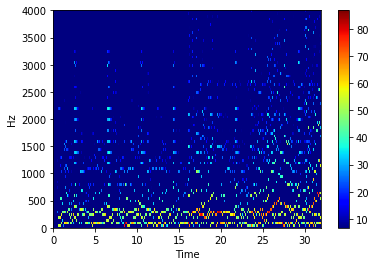

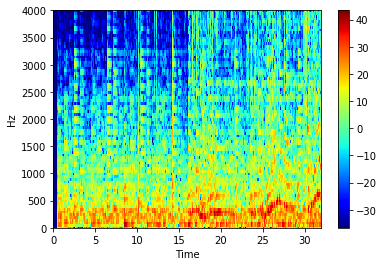

In [102]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(model)),cmap='jet',x_axis='time', y_axis='linear',sr=sample_rate)
plt.ylim([0,4000])
plt.xlim([0,32])
plt.colorbar()
plt.show()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stftMat)),cmap = 'jet',x_axis='time', y_axis='linear',sr=sample_rate)
plt.ylim([0,4000])
plt.xlim([0,32])
plt.colorbar()
plt.show()

In [103]:
 sf.write(os.path.join(base_dir,'ha gente aqui sintetizado.wav'), synt, sample_rate, 'PCM_24')